In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import rasterio
import numpy as np
import torch.nn as nn
import torch.optim as optim
from skimage.transform import resize
from tqdm import tqdm
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.features import geometry_mask
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tif_path = "G:/16_ECMWF/7_climate_10_520_400/1_tem/2017/tem_2017_01_01.tif"
with rasterio.open(tif_path) as src:
        image_data = src.read(1)  # 读取第一个波段
        transform = src.transform
        crs = src.crs
        bounds = src.bounds
        height, width = src.height, src.width
        profile = src.profile  # 获取文件元数据以便后续导出
    
shp_path = "C:/Users/Administrator/Desktop/边界/九大农业区/Agr_qu.shp"
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(crs)
geometries = [mapping(geometry) for geometry in shapefile.geometry]
mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=(height, width))

Using device: cuda


In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, tem_dirs, tem_min_dirs, tem_max_dirs, pr_dirs, wind_dirs, ps_dirs, solar_dirs, ther_dirs, rh_dirs, eva_dirs, transform=None):
        self.tem_files = self._get_all_files(tem_dirs)
        self.tem_min_files = self._get_all_files(tem_min_dirs)
        self.tem_max_files = self._get_all_files(tem_max_dirs)
        self.pr_files = self._get_all_files(pr_dirs)
        self.wind_files = self._get_all_files(wind_dirs)
        self.ps_files = self._get_all_files(ps_dirs)
        self.solar_files = self._get_all_files(solar_dirs)
        self.ther_files = self._get_all_files(ther_dirs)
        self.rh_files = self._get_all_files(rh_dirs)
        self.eva_files = self._get_all_files(eva_dirs)
        
        self.transform = transform

    def _get_all_files(self, dirs):
        all_files = []
        for directory in dirs:
            for filename in sorted(os.listdir(directory)):  # 排序保证匹配
                file_path = os.path.join(directory, filename)
                if os.path.isfile(file_path):  # 确保是文件
                    all_files.append(file_path)
        return all_files

    def __len__(self):
        return len(self.tem_files)

    def __getitem__(self, idx):
        tem_path = self.tem_files[idx]
        tem_min_path = self.tem_min_files[idx]
        tem_max_path = self.tem_max_files[idx]
        pr_path = self.pr_files[idx]
        wind_path = self.wind_files[idx]
        ps_path = self.ps_files[idx]
        solar_path = self.solar_files[idx]
        ther_path = self.ther_files[idx]
        rh_path = self.rh_files[idx]
        eva_path = self.eva_files[idx]
        
        with rasterio.open(tem_path) as tem_dataset:
            tem_image = tem_dataset.read(1)  
        with rasterio.open(tem_min_path) as tem_min_dataset:
            tem_min_image = tem_min_dataset.read(1)  
        with rasterio.open(tem_max_path) as tem_max_dataset:
            tem_max_image = tem_max_dataset.read(1)  
        with rasterio.open(pr_path) as pr_dataset:
            pr_image = pr_dataset.read(1)
            pr_image = pr_image*1000
        with rasterio.open(wind_path) as wind_dataset:
            wind_image = wind_dataset.read(1)  
        with rasterio.open(ps_path) as ps_dataset:
            ps_image = ps_dataset.read(1)  
            ps_image = ps_image/1000
        with rasterio.open(solar_path) as solar_dataset:
            solar_image = solar_dataset.read(1) 
            solar_image = solar_image/86400
        with rasterio.open(ther_path) as ther_dataset:
            ther_image = ther_dataset.read(1) 
            ther_image = ther_image/86400
        with rasterio.open(rh_path) as rh_dataset:
            rh_image = rh_dataset.read(1) 
        with rasterio.open(eva_path) as eva_dataset:
            eva_image = eva_dataset.read(1) 

        # 如果有 transform，应用转换
        if self.transform:
            tem_image = self.transform(tem_image)
            tem_min_image = self.transform(tem_min_image)
            tem_max_image = self.transform(tem_max_image)
            pr_image = self.transform(pr_image)
            wind_image = self.transform(wind_image)
            ps_image = self.transform(ps_image)
            solar_image = self.transform(solar_image)
            ther_image = self.transform(ther_image)
            rh_image = self.transform(rh_image)
            eva_image = self.transform(eva_image)

        else:
        # 如果没有 transform，转换为 PyTorch 张量
            tem_image = torch.from_numpy(tem_image).float()  # (1, H, W)
            tem_min_image = torch.from_numpy(tem_min_image).float()  # (1, H, W)
            tem_max_image = torch.from_numpy(tem_max_image).float()  # (1, H, W)
            pr_image = torch.from_numpy(pr_image).float()  # (1, H, W)
            wind_image = torch.from_numpy(wind_image).float()  # (1, H, W)
            ps_image = torch.from_numpy(ps_image).float()  # (1, H, W)
            solar_image = torch.from_numpy(solar_image).float()  # (1, H, W)
            ther_image = torch.from_numpy(ther_image).float()  # (1, H, W)
            rh_image = torch.from_numpy(rh_image).float()  # (1, H, W)
            eva_image = torch.from_numpy(eva_image).float()  # (1, H, W)

        lr_image =  torch.cat([tem_image, tem_min_image,tem_max_image,pr_image,wind_image,ps_image,solar_image,ther_image,rh_image], dim=0)
            
        return lr_image, eva_image
# 定义数据增强和预处理操作
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # 将 NumPy 数组转换为 PyTorch 张量
])

def load_tiff_with_rasterio(file_path):
    with rasterio.open(file_path) as src:
        img = src.read(1)  # 读取第一个波段
        img = img
    return img

In [4]:
year = list(range(2000,2014))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_train = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0)


year = list(range(2014,2019))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_val = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=True, num_workers=0)


year = list(range(2019,2024))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_test = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=0)

In [5]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader):
        inputs  = inputs.float().to(device)
        targets = targets.float().to(device)

        inputs[torch.isnan(inputs)] = 0
        targets[torch.isnan(targets)] = 0

        assert not torch.isnan(inputs).any(), "Input contains NaN values"
        assert not torch.isnan(targets).any(), "Target contains NaN values"
        
        optimizer.zero_grad()
        outputs_up = model(inputs)

        loss = criterion(outputs_up, targets).to(device)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.float().to(device)
            targets =  targets.float().to(device)
            inputs[torch.isnan(inputs)] = 0
            targets[torch.isnan(targets)] = 0

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [6]:
import torch
import torch.nn as nn

class IEEB(nn.Module):
    """Information Extraction and Enhancement Block"""
    def __init__(self, in_channels, out_channels):
        super(IEEB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act = nn.PReLU()
        
    def forward(self, x):
        out1 = self.act(self.conv1(x))
        out2 = self.act(self.conv2(out1))
        out3 = self.act(self.conv3(out2))
        out4 = self.act(self.conv4(out3))
        out5 = self.conv5(out4)
        return out5 + x

class RB(nn.Module):
    """Reconstruction Block"""
    def __init__(self, channels):
        super(RB, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.act = nn.PReLU()
        
    def forward(self, x):
        out = self.act(self.conv1(x))
        out = self.conv2(out)
        return out + x

class IRB(nn.Module):
    """Information Refinement Block"""
    def __init__(self, channels):
        super(IRB, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.act = nn.PReLU()
        
    def forward(self, x):
        out1 = self.act(self.conv1(x))
        out2 = self.act(self.conv2(out1))
        out3 = self.conv3(out2)
        return out3 + x

class LESRCNN(nn.Module):
    def __init__(self, in_channels=9, out_channels=1, num_channels=64, scale_factor=10):
        super(LESRCNN, self).__init__()
        
        # 初始特征提取
        self.init_feature = nn.Sequential(
            nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1),
            nn.PReLU()
        )
        
        # 信息提取和增强块
        self.ieeb = IEEB(num_channels, num_channels)
        
        # 重建块
        self.rb = RB(num_channels)
        
        # 信息精炼块
        self.irb = IRB(num_channels)
        
        # 上采样块
        self.upsampler = nn.Sequential(
            nn.Conv2d(num_channels, num_channels * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.PReLU()
        )
        
        # 最终重建
        self.final_conv = nn.Conv2d(num_channels, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        # 初始特征提取
        init_feat = self.init_feature(x)
        
        # 信息提取和增强
        ieeb_out = self.ieeb(init_feat)
        
        # 重建
        rb_out = self.rb(ieeb_out)
        
        # 信息精炼
        irb_out = self.irb(rb_out)
        
        # 上采样
        up_out = self.upsampler(irb_out)
        
        # 最终重建
        out = self.final_conv(up_out)
        
        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = LESRCNN(in_channels=9, out_channels=1, num_channels=64, scale_factor=10).to(device)

learning_rate = 0.0001
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

num_epochs = 100
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Model is training on: {next(model.parameters()).device}')
    train_loss = train_model(model, dataloader_train, criterion, optimizer, device)
    val_loss = validate_model(model, dataloader_val, criterion, device)
    print(f'Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'G:/16_ECMWF/13_DL_modle/1_climate_520_400/13_pet/LESRCNN_pet.pth')
        print('Model saved!')

cuda
Epoch 1/100
Model is training on: cuda:0


  1%|          | 3/320 [00:02<05:11,  1.02it/s]


KeyboardInterrupt: 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13696\3521585872.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('G:/16_ECMWF/13_DL_

torch.Size([1, 1, 40, 52])
torch.Size([1, 9, 40, 52])


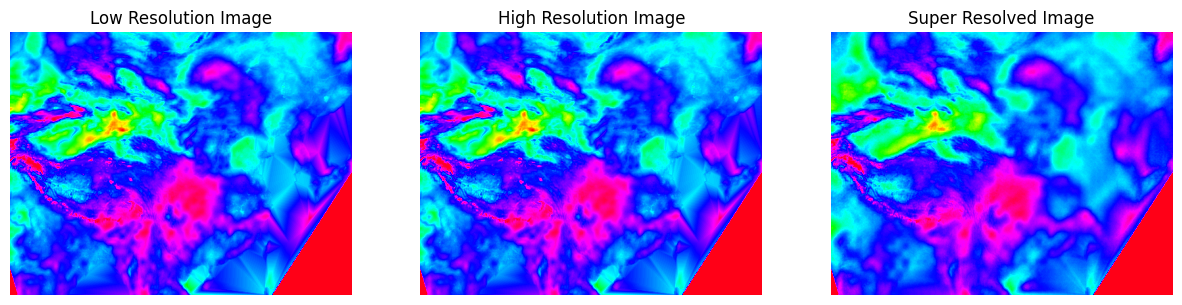

In [8]:
model = LESRCNN(in_channels=9, out_channels=1, num_channels=64, scale_factor=10).to(device)
model.load_state_dict(torch.load('G:/16_ECMWF/13_DL_modle/1_climate_520_400/13_pet/LESRCNN_pet.pth'))
model.eval()  # 设置为评估模式

eva_image_path = 'D:/7_climate_10_520_400/12_PET/2020/PET_2020_07_01.tif'
tem_image_path = 'F:/3_climate_100_52_40/1_tem/2020/tem_2020_07_01.tif'
tem_min_image_path = 'F:/3_climate_100_52_40/3_tem_min/2020/tem_min_2020_07_01.tif'
tem_max_image_path = 'F:/3_climate_100_52_40/2_tem_max/2020/tem_max_2020_07_01.tif'
pr_image_path = 'F:/3_climate_100_52_40/7_tol_per/2020/per_2020_07_01.tif'
wind_image_path = 'F:/3_climate_100_52_40/4_wind_u/2020/wind_2020_07_01.tif'
ps_image_path = 'F:/3_climate_100_52_40/6_ps/2020/ps_2020_07_01.tif'
solar_image_path = 'F:/3_climate_100_52_40/8_solar_rad/2020/solar_rad_2020_07_01.tif'
ther_image_path = 'F:/3_climate_100_52_40/9_ther_rad/2020/ther_rad_2020_07_01.tif'
rh_image_path = 'F:/3_climate_100_52_40/11_rh/2020/rh_2020_07_01.tif'

eva_image = load_tiff_with_rasterio(eva_image_path)
tem_image = load_tiff_with_rasterio(tem_image_path)
tem_min_image = load_tiff_with_rasterio(tem_min_image_path)
tem_max_image = load_tiff_with_rasterio(tem_max_image_path)
pr_image = load_tiff_with_rasterio(pr_image_path)
pr_image = pr_image*1000
wind_image = load_tiff_with_rasterio(wind_image_path)
ps_image = load_tiff_with_rasterio(ps_image_path)
ps_image = ps_image/1000
solar_image = load_tiff_with_rasterio(solar_image_path)
solar_image = solar_image/86400
ther_image = load_tiff_with_rasterio(ther_image_path)
ther_image = ther_image/86400
rh_image = load_tiff_with_rasterio(rh_image_path)

transform = transforms.ToTensor()
tem_tensor = transform(tem_image).unsqueeze(0)
tem_min_tensor = transform(tem_min_image).unsqueeze(0)
tem_max_tensor = transform(tem_max_image).unsqueeze(0)
pr_tensor = transform(pr_image).unsqueeze(0)
wind_tensor = transform(wind_image).unsqueeze(0)
ps_tensor = transform(ps_image).unsqueeze(0)
solar_tensor = transform(solar_image).unsqueeze(0)
ther_tensor = transform(ther_image).unsqueeze(0)
rh_tensor = transform(rh_image).unsqueeze(0)
print(ther_tensor.shape)
lr_tensor= torch.cat([tem_tensor,tem_min_tensor,tem_max_tensor,pr_tensor,wind_tensor,ps_tensor,solar_tensor,ther_tensor,rh_tensor],dim=1)
print(lr_tensor.shape)
lr_tensor = lr_tensor.float().to(device)

vmin = eva_image[mask].min()
vmax = eva_image[mask].max()

model.to(device)
with torch.no_grad():
    sr_tensor = model(lr_tensor)
sr_image = sr_tensor.squeeze().cpu().numpy()

def plot_images(lr_image, hr_image, sr_image):


    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('Low Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(hr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('High Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('Super Resolved Image')
    plt.axis('off')

    plt.show()
plot_images(eva_image, eva_image, sr_image)

In [10]:
with rasterio.open(eva_image_path) as src:
    # 获取原始图像的地理信息（仿射变换矩阵和投影坐标系）
    transform = src.transform
    crs = src.crs
    profile = src.profile
profile.update(
    dtype=rasterio.float32,   # 数据类型为 float32
    count=1,                  # 1 个波段
    height=sr_image.shape[0], # 高度
    width=sr_image.shape[1],  # 宽度
    transform=transform        # 保持原始的地理变换信息
)

year = list(range(2000, 2024))
model.to(device)
transform = transforms.ToTensor()
for a_index, a in enumerate(year):
    start_date = f'{a}-01-01'
    end_date = f'{a}-12-31'
    date_range = pd.date_range(start=start_date, end=end_date)
    print(a)
    for b_index, b in enumerate(date_range):
        day_index = b_index
        date_day = date_range[day_index]
        date_day_year = date_day.year
        date_day_month = date_day.month
        date_day_day = date_day.day
        tem_path = f'F:/3_climate_100_52_40/1_tem/{a}/tem_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}/tem_min_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}/tem_max_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}/per_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}/wind_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        ps_path = f'F:/3_climate_100_52_40/6_ps/{a}/ps_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}/solar_rad_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}/ther_rad_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        rh_path = f'F:/3_climate_100_52_40/11_rh/{a}/rh_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        
        output_path = f'J:/3_climate_output/1_climate_520_400/5_LESRCNN/12_pet/{a}/pet_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        
        tem_image = load_tiff_with_rasterio(tem_path)
        tem_tensor = transform(tem_image).unsqueeze(0) 
        tem_tensor = tem_tensor.float().to(device)
        
        tem_min_image = load_tiff_with_rasterio(tem_min_path)
        tem_min_tensor = transform(tem_min_image).unsqueeze(0) 
        tem_min_tensor = tem_min_tensor.float().to(device)

        tem_max_image = load_tiff_with_rasterio(tem_max_path)
        tem_max_tensor = transform(tem_max_image).unsqueeze(0) 
        tem_max_tensor = tem_max_tensor.float().to(device)

        pr_image = load_tiff_with_rasterio(pr_path)
        pr_image = pr_image*1000
        pr_tensor = transform(pr_image).unsqueeze(0) 
        pr_tensor = pr_tensor.float().to(device)

        ps_image = load_tiff_with_rasterio(ps_path)
        ps_image = ps_image/1000
        ps_tensor = transform(ps_image).unsqueeze(0) 
        ps_tensor = ps_tensor.float().to(device)

        wind_image = load_tiff_with_rasterio(wind_path)
        wind_tensor = transform(wind_image).unsqueeze(0) 
        wind_tensor = wind_tensor.float().to(device)

        solar_image = load_tiff_with_rasterio(solar_path)
        solar_image = solar_image/86400
        solar_tensor = transform(solar_image).unsqueeze(0) 
        solar_tensor = solar_tensor.float().to(device)

        ther_image = load_tiff_with_rasterio(ther_path)
        ther_image = ther_image/86400
        ther_tensor = transform(ther_image).unsqueeze(0) 
        ther_tensor = ther_tensor.float().to(device)

        rh_image = load_tiff_with_rasterio(rh_path)
        rh_tensor = transform(rh_image).unsqueeze(0) 
        rh_tensor = rh_tensor.float().to(device)

        lr_tensor = torch.cat([tem_tensor,tem_min_tensor,tem_max_tensor,pr_tensor,wind_tensor,ps_tensor,solar_tensor,ther_tensor,rh_tensor],dim=1)
        
        with torch.no_grad():
            sr_tensor = model(lr_tensor)
        sr_image = sr_tensor.squeeze().cpu().numpy()
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(sr_image.astype(rasterio.float32), 1)  # 将 sr_image 写入为第一个波段

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
